In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import re
import string
import os

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from math import ceil

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN

In [4]:
#plt.style.use('fivethirtyeight')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
import sklearn.cluster as sklc
import sklearn.metrics as sklm
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy import stats
from scipy.stats import bartlett
import plotly.graph_objs as go
import plotly.offline as py

In [5]:
df = pd.read_csv('year_lsoa_grocery.csv')

In [6]:
df

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,man_day,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km
0,E01000001,308.119047,35.0,150.0,250.0,400.0,900.0,266.851723,2.359404,97.218600,...,16033,1296.0,685.0,611.0,179.0,766.0,351.0,48.293981,0.13,9985.0
1,E01000002,313.517874,40.0,150.0,250.0,400.0,900.0,256.227843,2.833812,88.262314,...,7829,1156.0,616.0,540.0,197.0,656.0,303.0,47.398789,0.23,5061.0
2,E01000003,315.084751,35.0,150.0,250.0,400.0,1000.0,292.462262,2.763918,102.240558,...,15065,1350.0,713.0,637.0,152.0,850.0,348.0,48.360741,0.06,22843.0
3,E01000005,356.033437,38.0,150.0,280.0,450.0,1000.0,436.559315,2.554110,113.968805,...,25128,1121.0,604.0,517.0,294.0,675.0,152.0,35.611954,0.19,5912.0
4,E01000006,451.262063,36.0,180.0,325.0,500.0,1500.0,666.655869,7.744708,133.322097,...,5860,2040.0,1040.0,1000.0,563.0,1317.0,160.0,32.080392,0.15,13915.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4828,E01033742,387.401492,37.5,170.0,300.0,500.0,1000.0,402.790826,2.671220,100.481483,...,17579,1701.0,902.0,799.0,335.0,1241.0,125.0,33.250441,0.13,13532.0
4829,E01033743,420.188421,33.0,170.0,340.0,500.0,1500.0,495.895799,4.655028,106.949648,...,9817,2426.0,1225.0,1201.0,844.0,1494.0,88.0,29.259275,1.00,2423.0
4830,E01033744,402.531751,35.0,170.0,300.0,500.0,1200.0,499.572412,3.129316,113.476785,...,18734,1900.0,964.0,936.0,549.0,1220.0,131.0,31.960526,0.15,12952.0
4831,E01033745,435.686457,40.0,182.0,350.0,500.0,1500.0,536.871624,6.140228,120.670999,...,6892,1954.0,961.0,993.0,680.0,1202.0,72.0,30.143296,0.56,3465.0


# *Clustering map*: 
### step 1: geometry centroid of LSOA level

In [7]:
shp = gpd.read_file('lsoa/LSOA_2011_London_gen_MHW.shp')
shp = shp.to_crs('epsg:27700')

<AxesSubplot:>

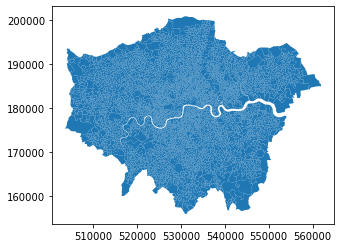

In [8]:
shp.plot()

In [9]:
shp

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,0,112.9,876,1.7,"POLYGON ((532105.092 182011.230, 532162.491 18..."
1,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,0,62.9,830,1.7,"POLYGON ((532746.813 181786.891, 532671.688 18..."
2,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,E12000007,London,1346,1250,96,227.7,817,1.5,"POLYGON ((532135.145 182198.119, 532158.250 18..."
3,E01000005,City of London 001E,E02000001,City of London 001,E09000001,City of London,E12000007,London,985,985,0,52.0,467,2.1,"POLYGON ((533807.946 180767.770, 533649.063 18..."
4,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,E12000007,London,1703,1699,4,116.2,543,3.1,"POLYGON ((545122.049 184314.931, 545271.917 18..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,E01033742,Greenwich 007F,E02000319,Greenwich 007,E09000011,Greenwich,E12000007,London,1352,1352,0,107.6,581,2.3,"POLYGON ((544642.680 179824.674, 544766.313 17..."
4831,E01033743,Greenwich 002H,E02000314,Greenwich 002,E09000011,Greenwich,E12000007,London,2038,2038,0,20.4,663,3.1,"POLYGON ((546579.195 181097.813, 546687.036 18..."
4832,E01033744,Greenwich 007G,E02000319,Greenwich 007,E09000011,Greenwich,E12000007,London,1845,1728,117,125.8,646,2.7,"POLYGON ((544536.486 179447.115, 544602.630 17..."
4833,E01033745,Greenwich 002I,E02000314,Greenwich 002,E09000011,Greenwich,E12000007,London,1820,1820,0,32.3,591,3.1,"POLYGON ((546415.745 180152.270, 546320.715 18..."


In [10]:
cents = shp.centroid
dff1 = pd.DataFrame(data=cents.values, index=shp['LSOA11CD'])
dff1

,0
LSOA11CD,
E01000001,POINT (532150.879 181615.038)
E01000002,POINT (532443.354 181645.862)
E01000003,POINT (532207.062 182030.087)
E01000005,POINT (533618.591 181157.118)
E01000006,POINT (544934.368 184297.551)
...,...
E01033742,POINT (544581.697 179602.539)
E01033743,POINT (545763.532 180611.459)
E01033744,POINT (544541.222 179300.528)


In [11]:
dff1 = dff1.reset_index()

In [12]:
dff1 = dff1.rename(columns={0: 'geometry'})

In [13]:
lsoa0 = shp[['LSOA11CD','LSOA11NM','LAD11NM']].copy()

In [14]:
lsoa_cents = pd.merge(dff1, lsoa0, how='left', left_on='LSOA11CD', right_on='LSOA11CD')

In [15]:
lsoa_cents

,LSOA11CD,geometry,LSOA11NM,LAD11NM
0,E01000001,POINT (532150.879 181615.038),City of London 001A,City of London
1,E01000002,POINT (532443.354 181645.862),City of London 001B,City of London
2,E01000003,POINT (532207.062 182030.087),City of London 001C,City of London
3,E01000005,POINT (533618.591 181157.118),City of London 001E,City of London
4,E01000006,POINT (544934.368 184297.551),Barking and Dagenham 016A,Barking and Dagenham
...,...,...,...,...
4830,E01033742,POINT (544581.697 179602.539),Greenwich 007F,Greenwich
4831,E01033743,POINT (545763.532 180611.459),Greenwich 002H,Greenwich
4832,E01033744,POINT (544541.222 179300.528),Greenwich 007G,Greenwich
4833,E01033745,POINT (546171.331 180005.443),Greenwich 002I,Greenwich


In [16]:
dfx = pd.merge(df, lsoa_cents, how='left', left_on='area_id', right_on='LSOA11CD')
dfx

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km,LSOA11CD,geometry,LSOA11NM,LAD11NM
0,E01000001,308.119047,35.0,150.0,250.0,400.0,900.0,266.851723,2.359404,97.218600,...,179.0,766.0,351.0,48.293981,0.13,9985.0,E01000001,POINT (532150.879 181615.038),City of London 001A,City of London
1,E01000002,313.517874,40.0,150.0,250.0,400.0,900.0,256.227843,2.833812,88.262314,...,197.0,656.0,303.0,47.398789,0.23,5061.0,E01000002,POINT (532443.354 181645.862),City of London 001B,City of London
2,E01000003,315.084751,35.0,150.0,250.0,400.0,1000.0,292.462262,2.763918,102.240558,...,152.0,850.0,348.0,48.360741,0.06,22843.0,E01000003,POINT (532207.062 182030.087),City of London 001C,City of London
3,E01000005,356.033437,38.0,150.0,280.0,450.0,1000.0,436.559315,2.554110,113.968805,...,294.0,675.0,152.0,35.611954,0.19,5912.0,E01000005,POINT (533618.591 181157.118),City of London 001E,City of London
4,E01000006,451.262063,36.0,180.0,325.0,500.0,1500.0,666.655869,7.744708,133.322097,...,563.0,1317.0,160.0,32.080392,0.15,13915.0,E01000006,POINT (544934.368 184297.551),Barking and Dagenham 016A,Barking and Dagenham
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4828,E01033742,387.401492,37.5,170.0,300.0,500.0,1000.0,402.790826,2.671220,100.481483,...,335.0,1241.0,125.0,33.250441,0.13,13532.0,E01033742,POINT (544581.697 179602.539),Greenwich 007F,Greenwich
4829,E01033743,420.188421,33.0,170.0,340.0,500.0,1500.0,495.895799,4.655028,106.949648,...,844.0,1494.0,88.0,29.259275,1.00,2423.0,E01033743,POINT (545763.532 180611.459),Greenwich 002H,Greenwich
4830,E01033744,402.531751,35.0,170.0,300.0,500.0,1200.0,499.572412,3.129316,113.476785,...,549.0,1220.0,131.0,31.960526,0.15,12952.0,E01033744,POINT (544541.222 179300.528),Greenwich 007G,Greenwich
4831,E01033745,435.686457,40.0,182.0,350.0,500.0,1500.0,536.871624,6.140228,120.670999,...,680.0,1202.0,72.0,30.143296,0.56,3465.0,E01033745,POINT (546171.331 180005.443),Greenwich 002I,Greenwich


In [17]:
gdf = gpd.GeoDataFrame(dfx, geometry='geometry')

<AxesSubplot:>

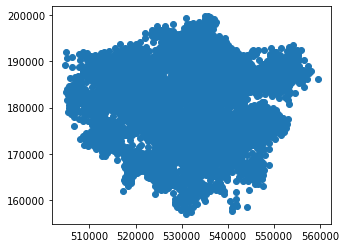

In [18]:
gdf.plot()

In [19]:
dfna = gdf[gdf.isna().any(axis=1)]

In [20]:
dfna

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km,LSOA11CD,geometry,LSOA11NM,LAD11NM


## Step 2: spatial join, 4833 points to 625 wards

In [21]:
ward = gpd.read_file('shp01/London_Ward_CityMerged.shp')
ward = ward.to_crs('epsg:27700')

In [22]:
gdf_lsoa = gpd.sjoin(gdf, ward, op='within', how='left')

In [23]:
gdf_lsoa

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,LSOA11NM,LAD11NM,index_right,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID
0,E01000001,308.119047,35.0,150.0,250.0,400.0,900.0,266.851723,2.359404,97.218600,...,City of London 001A,City of London,624,City of London,E09000001,314.943,24.546,E09000001,City of London,122502
1,E01000002,313.517874,40.0,150.0,250.0,400.0,900.0,256.227843,2.833812,88.262314,...,City of London 001B,City of London,624,City of London,E09000001,314.943,24.546,E09000001,City of London,122502
2,E01000003,315.084751,35.0,150.0,250.0,400.0,1000.0,292.462262,2.763918,102.240558,...,City of London 001C,City of London,624,City of London,E09000001,314.943,24.546,E09000001,City of London,122502
3,E01000005,356.033437,38.0,150.0,280.0,450.0,1000.0,436.559315,2.554110,113.968805,...,City of London 001E,City of London,624,City of London,E09000001,314.943,24.546,E09000001,City of London,122502
4,E01000006,451.262063,36.0,180.0,325.0,500.0,1500.0,666.655869,7.744708,133.322097,...,Barking and Dagenham 016A,Barking and Dagenham,611,Abbey,E05000026,128.292,2.655,E09000002,Barking and Dagenham,51353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4828,E01033742,387.401492,37.5,170.0,300.0,500.0,1000.0,402.790826,2.671220,100.481483,...,Greenwich 007F,Greenwich,282,Glyndon,E05000221,170.196,15.420,E09000011,Greenwich,117379
4829,E01033743,420.188421,33.0,170.0,340.0,500.0,1500.0,495.895799,4.655028,106.949648,...,Greenwich 002H,Greenwich,283,Thamesmead Moorings,E05000228,481.256,89.362,E09000011,Greenwich,50872
4830,E01033744,402.531751,35.0,170.0,300.0,500.0,1200.0,499.572412,3.129316,113.476785,...,Greenwich 007G,Greenwich,282,Glyndon,E05000221,170.196,15.420,E09000011,Greenwich,117379
4831,E01033745,435.686457,40.0,182.0,350.0,500.0,1500.0,536.871624,6.140228,120.670999,...,Greenwich 002I,Greenwich,283,Thamesmead Moorings,E05000228,481.256,89.362,E09000011,Greenwich,50872


In [24]:
cols = ['GSS_CODE','weight','weight_perc2.5','weight_perc25','weight_perc50','weight_perc75','weight_perc97.5','weight_std','weight_ci95','volume','volume_perc2.5','volume_perc25','volume_perc50','volume_perc75','volume_perc97.5','volume_std','volume_ci95',
        'fat','fat_perc2.5','fat_perc25','fat_perc50','fat_perc75','fat_perc97.5','fat_std','fat_ci95','saturate','saturate_perc2.5','saturate_perc25','saturate_perc50','saturate_perc75',
        'saturate_perc97.5','saturate_std','saturate_ci95','salt','salt_perc2.5','salt_perc25','salt_perc50','salt_perc75','salt_perc97.5','salt_std','salt_ci95','sugar','sugar_perc2.5','sugar_perc25','sugar_perc50','sugar_perc75',
        'sugar_perc97.5','sugar_std','sugar_ci95','protein','protein_perc2.5','protein_perc25','protein_perc50','protein_perc75','protein_perc97.5','protein_std','protein_ci95','carb','carb_perc2.5','carb_perc25','carb_perc50','carb_perc75','carb_perc97.5',
        'carb_std','carb_ci95','fibre','fibre_perc2.5','fibre_perc25','fibre_perc50','fibre_perc75','fibre_perc97.5','fibre_std','fibre_ci95','alcohol','alcohol_perc2.5','alcohol_perc25','alcohol_perc50','alcohol_perc75','alcohol_perc97.5',
        'alcohol_std','alcohol_ci95','energy_fat','energy_fat_perc2.5','energy_fat_perc25','energy_fat_perc50','energy_fat_perc75','energy_fat_perc97.5','energy_fat_std',
        'energy_fat_ci95','energy_saturate','energy_saturate_perc2.5','energy_saturate_perc25','energy_saturate_perc50','energy_saturate_perc75','energy_saturate_perc97.5',
        'energy_saturate_std','energy_saturate_ci95','energy_sugar','energy_sugar_perc2.5','energy_sugar_perc25','energy_sugar_perc50','energy_sugar_perc75','energy_sugar_perc97.5','energy_sugar_std','energy_sugar_ci95','energy_protein','energy_protein_perc2.5',
'energy_protein_perc25','energy_protein_perc50','energy_protein_perc75','energy_protein_perc97.5','energy_protein_std','energy_protein_ci95','energy_carb','energy_carb_perc2.5','energy_carb_perc25','energy_carb_perc50','energy_carb_perc75','energy_carb_perc97.5',
        'energy_carb_std','energy_carb_ci95','energy_fibre','energy_fibre_perc2.5','energy_fibre_perc25','energy_fibre_perc50','energy_fibre_perc75','energy_fibre_perc97.5',
        'energy_fibre_std','energy_fibre_ci95','energy_alcohol','energy_alcohol_perc2.5','energy_alcohol_perc25','energy_alcohol_perc50','energy_alcohol_perc75','energy_alcohol_perc97.5',
        'energy_alcohol_std','energy_alcohol_ci95','energy_tot','energy_tot_perc2.5','energy_tot_perc25','energy_tot_perc50','energy_tot_perc75','energy_tot_perc97.5','energy_tot_std','energy_tot_ci95','f_energy_fat','f_energy_saturate','f_energy_sugar',
        'f_energy_protein','f_energy_carb','f_energy_fibre','f_energy_alcohol','energy_density','h_nutrients_weight','h_nutrients_weight_norm','h_nutrients_calories','h_nutrients_calories_norm','f_beer','f_dairy','f_eggs','f_fats_oils','f_fish','f_fruit_veg',
        'f_grains','f_meat_red','f_poultry','f_readymade','f_sauces','f_soft_drinks','f_spirits','f_sweets','f_tea_coffee','f_water','f_wine','f_dairy_weight','f_eggs_weight','f_fats_oils_weight','f_fish_weight','f_fruit_veg_weight','f_grains_weight',
        'f_meat_red_weight','f_poultry_weight','f_readymade_weight','f_sauces_weight','f_sweets_weight','h_items','h_items_norm','h_items_weight','h_items_weight_norm','representativeness_norm',
        'transaction_days','num_transactions','man_day','population','male','female','age_0_17','age_18_64','age_65+','avg_age','area_sq_km','people_per_sq_km']

In [25]:
lodata = gdf_lsoa.groupby('GSS_CODE')[cols].agg('mean').reset_index()

In [26]:
lodata

,GSS_CODE,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,man_day,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km
0,E05000026,449.285651,33.642857,164.914286,307.142857,500.000000,1671.428571,765.385866,10.080426,126.197530,...,5330.714286,2052.857143,1067.000000,985.857143,601.571429,1345.857143,105.428571,29.784617,0.180000,12595.000000
1,E05000027,410.996142,34.350000,158.666667,301.666667,485.000000,1316.666667,598.873157,12.095084,110.558674,...,2412.333333,1807.500000,871.333333,936.166667,534.166667,1101.333333,172.000000,33.760633,0.226667,8405.166667
2,E05000028,403.280778,32.187500,160.000000,298.125000,491.875000,1250.000000,560.236240,9.085263,121.636457,...,4017.250000,1732.000000,843.750000,888.250000,522.500000,1067.125000,142.375000,32.287723,0.161250,10768.375000
3,E05000029,384.643663,30.886667,144.166667,275.833333,463.166667,1174.875000,573.807375,11.912561,119.789772,...,2703.833333,1808.333333,883.333333,925.000000,503.833333,1041.833333,262.666667,36.168857,0.563333,5597.333333
4,E05000030,357.927792,29.410714,135.857143,260.714286,439.285714,1114.285714,466.710701,10.480222,110.099088,...,2503.142857,1621.142857,787.857143,833.285714,392.428571,994.428571,234.285714,37.281982,0.492857,5370.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,E05000646,389.085197,37.500000,168.333333,307.833333,485.666667,1083.333333,439.674050,6.792795,103.423170,...,3476.500000,1879.333333,990.333333,889.000000,304.666667,1319.333333,255.333333,39.097835,0.100000,23262.500000
621,E05000647,389.037331,38.200000,173.400000,323.000000,505.750000,980.000000,409.143876,6.712707,115.798598,...,2772.000000,2017.200000,1043.000000,974.200000,272.800000,1496.600000,247.800000,39.029760,0.116000,26042.600000
622,E05000648,399.558206,38.585714,169.800000,307.857143,487.142857,1200.000000,466.932743,3.717051,109.238069,...,13692.000000,1952.571429,958.428571,994.142857,498.857143,1264.428571,189.285714,34.848261,0.095714,21992.000000
623,E05000649,366.641629,39.666667,156.333333,273.333333,469.166667,1033.333333,414.677411,5.217129,97.056179,...,5483.500000,1971.166667,1170.000000,801.166667,188.666667,1562.500000,220.000000,39.767907,0.331667,7326.166667


In [27]:
df0 = lodata[['GSS_CODE','weight','volume','fat','saturate','salt','sugar','protein','carb','fibre','alcohol','energy_fat',
       'f_beer','f_dairy','f_eggs','f_fats_oils','f_fish','f_fruit_veg','f_grains','f_meat_red','f_poultry','f_readymade','f_sauces',
        'f_soft_drinks','f_spirits','f_sweets','f_tea_coffee','f_water','f_wine','energy_density','h_nutrients_calories_norm']].copy()
df0

,GSS_CODE,weight,volume,fat,saturate,salt,sugar,protein,carb,fibre,...,f_readymade,f_sauces,f_soft_drinks,f_spirits,f_sweets,f_tea_coffee,f_water,f_wine,energy_density,h_nutrients_calories_norm
0,E05000026,449.285651,126.197530,9.570705,3.722551,0.583418,10.965605,4.969989,19.383810,1.554964,...,0.059287,0.012446,0.044698,0.004677,0.181599,0.005873,0.043386,0.009170,0.419519,0.659565
1,E05000027,410.996142,110.558674,9.644139,3.555931,0.567573,10.471003,5.235525,18.938432,1.585403,...,0.074011,0.011904,0.037118,0.005123,0.173070,0.005661,0.041074,0.007347,0.460073,0.664323
2,E05000028,403.280778,121.636457,9.243238,3.626066,0.601592,11.056659,5.131525,20.039167,1.580061,...,0.069275,0.014646,0.036208,0.004354,0.184966,0.006645,0.042156,0.008967,0.467511,0.664796
3,E05000029,384.643663,119.789772,9.632014,3.885444,0.545027,12.446272,4.822307,20.210055,1.575440,...,0.068164,0.012104,0.056007,0.004528,0.208983,0.006667,0.047324,0.007545,0.502677,0.653816
4,E05000030,357.927792,110.099088,9.411030,3.621396,0.567294,11.322950,5.310150,19.605787,1.608440,...,0.087491,0.009793,0.037138,0.002550,0.189662,0.006694,0.040556,0.009270,0.528415,0.662236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,E05000646,389.085197,103.423170,8.825969,3.385533,0.617304,9.337231,5.577878,17.468696,1.629174,...,0.061896,0.015609,0.029118,0.003019,0.145702,0.005585,0.029578,0.014779,0.454185,0.682591
621,E05000647,389.037331,115.798598,8.745594,3.438844,0.586279,9.523479,5.323244,17.564479,1.677169,...,0.062674,0.011596,0.027798,0.003642,0.145114,0.004888,0.026851,0.021826,0.453453,0.686855
622,E05000648,399.558206,109.238069,8.958494,3.524265,0.547340,9.677433,5.256326,17.960296,1.615851,...,0.046675,0.012613,0.022275,0.002472,0.154076,0.006412,0.036973,0.015664,0.446102,0.673176
623,E05000649,366.641629,97.056179,9.236482,3.676092,0.563918,10.263891,5.379970,18.157931,1.684520,...,0.046005,0.011706,0.024346,0.003095,0.165855,0.006628,0.030159,0.013603,0.506448,0.675562


In [28]:
df2 = df0[['weight','volume','fat','saturate','salt','sugar','protein','carb','fibre','alcohol','energy_fat',
           'f_beer','f_dairy','f_eggs','f_fats_oils','f_fish','f_fruit_veg','f_grains','f_meat_red','f_poultry',
           'f_readymade','f_sauces','f_soft_drinks','f_spirits','f_sweets','f_tea_coffee','f_water','f_wine','energy_density',
           'h_nutrients_calories_norm']].copy()

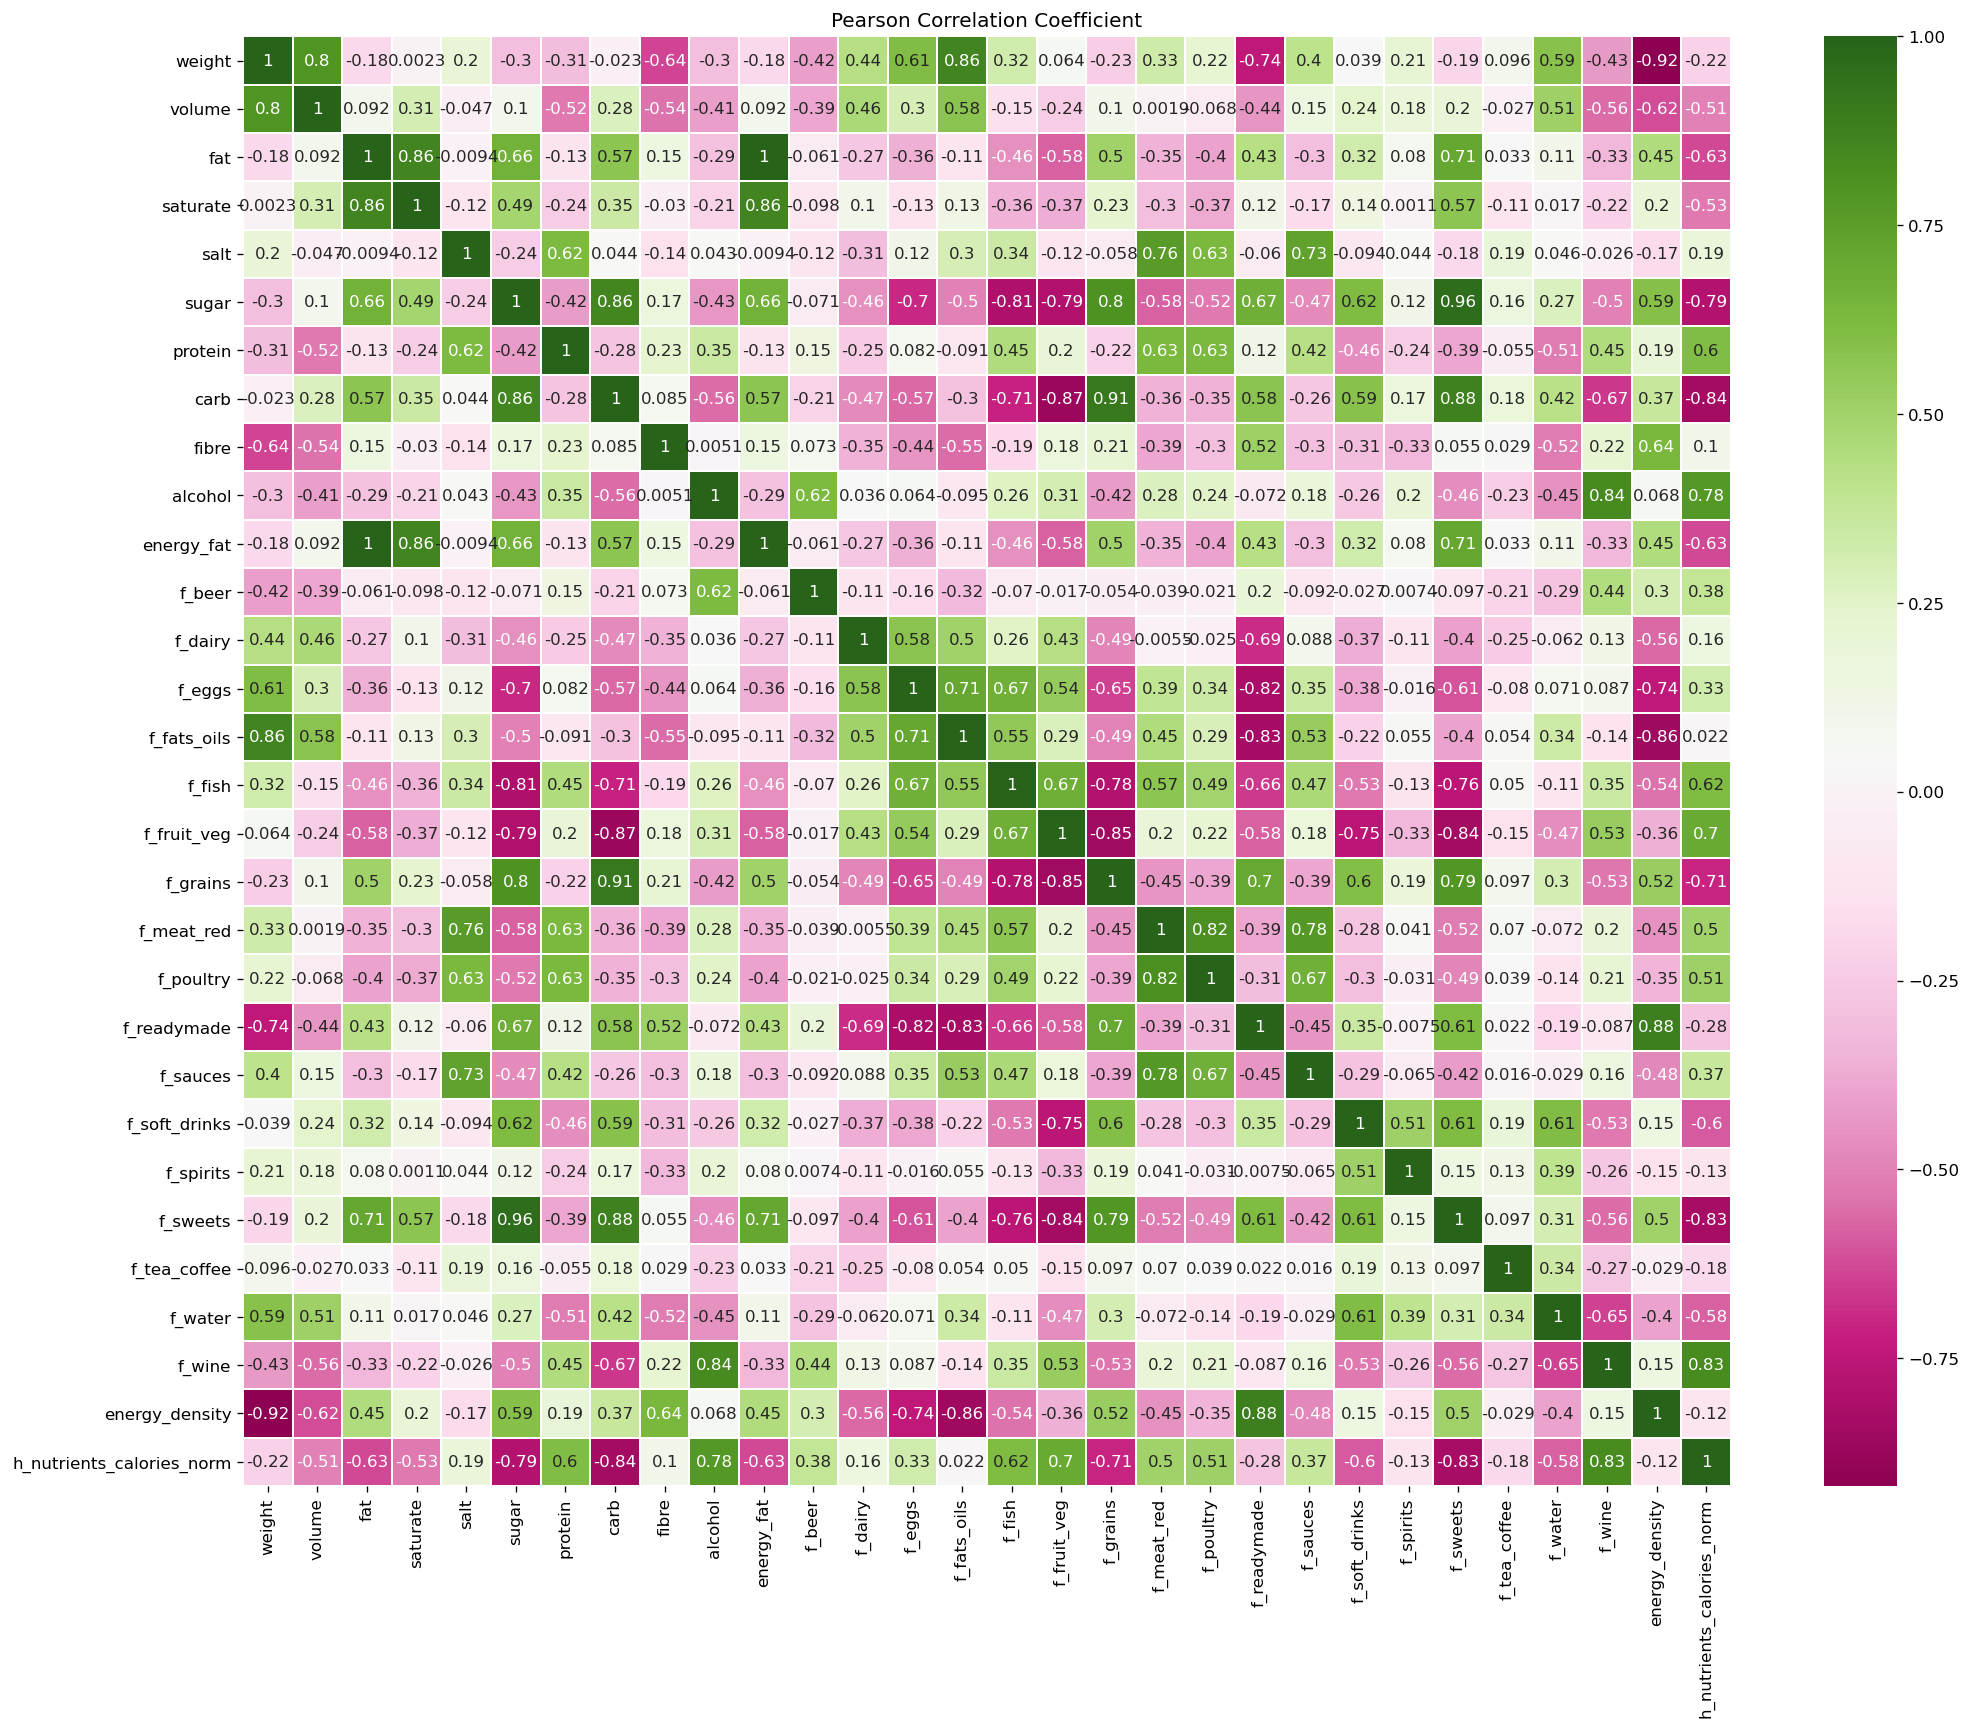

In [29]:
#sns.set_style("whitegrid")
#plt.style.use()
corr_heatmap=df2
x=corr_heatmap.corr(method='pearson')

plt.figure(figsize=(20,16), dpi= 120)
sns.heatmap(x,cmap='PiYG',annot=True,linewidth=0.2)
plt.title('Pearson Correlation Coefficient')
plt.xticks(rotation=90)
plt.savefig('pearson.jpg', dpi=400)

In [30]:
dfc = df0[['GSS_CODE','weight','volume','fat','saturate','salt','sugar','protein','fibre','alcohol',
           'f_beer','f_dairy','f_eggs','f_fats_oils','f_fish','f_fruit_veg','f_grains','f_meat_red','f_poultry',
           'f_readymade','f_sauces','f_soft_drinks','f_spirits','f_tea_coffee','f_water','f_wine','energy_density',
           'h_nutrients_calories_norm']].copy().set_index('GSS_CODE')
dfc

,weight,volume,fat,saturate,salt,sugar,protein,fibre,alcohol,f_beer,...,f_poultry,f_readymade,f_sauces,f_soft_drinks,f_spirits,f_tea_coffee,f_water,f_wine,energy_density,h_nutrients_calories_norm
GSS_CODE,,,,,,,,,,,,,,,,,,,,,
E05000026,449.285651,126.197530,9.570705,3.722551,0.583418,10.965605,4.969989,1.554964,0.207648,0.010961,...,0.018176,0.059287,0.012446,0.044698,0.004677,0.005873,0.043386,0.009170,0.419519,0.659565
E05000027,410.996142,110.558674,9.644139,3.555931,0.567573,10.471003,5.235525,1.585403,0.208692,0.013638,...,0.018682,0.074011,0.011904,0.037118,0.005123,0.005661,0.041074,0.007347,0.460073,0.664323
E05000028,403.280778,121.636457,9.243238,3.626066,0.601592,11.056659,5.131525,1.580061,0.227537,0.009612,...,0.016982,0.069275,0.014646,0.036208,0.004354,0.006645,0.042156,0.008967,0.467511,0.664796
E05000029,384.643663,119.789772,9.632014,3.885444,0.545027,12.446272,4.822307,1.575440,0.195584,0.009262,...,0.015785,0.068164,0.012104,0.056007,0.004528,0.006667,0.047324,0.007545,0.502677,0.653816
E05000030,357.927792,110.099088,9.411030,3.621396,0.567294,11.322950,5.310150,1.608440,0.165397,0.009585,...,0.019977,0.087491,0.009793,0.037138,0.002550,0.006694,0.040556,0.009270,0.528415,0.662236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E05000646,389.085197,103.423170,8.825969,3.385533,0.617304,9.337231,5.577878,1.629174,0.214264,0.011422,...,0.022488,0.061896,0.015609,0.029118,0.003019,0.005585,0.029578,0.014779,0.454185,0.682591
E05000647,389.037331,115.798598,8.745594,3.438844,0.586279,9.523479,5.323244,1.677169,0.300202,0.010654,...,0.017348,0.062674,0.011596,0.027798,0.003642,0.004888,0.026851,0.021826,0.453453,0.686855
E05000648,399.558206,109.238069,8.958494,3.524265,0.547340,9.677433,5.256326,1.615851,0.189467,0.006790,...,0.018110,0.046675,0.012613,0.022275,0.002472,0.006412,0.036973,0.015664,0.446102,0.673176


In [31]:
dfna = dfc[dfc.isna().any(axis=1)]

In [32]:
dfna

,weight,volume,fat,saturate,salt,sugar,protein,fibre,alcohol,f_beer,...,f_poultry,f_readymade,f_sauces,f_soft_drinks,f_spirits,f_tea_coffee,f_water,f_wine,energy_density,h_nutrients_calories_norm
GSS_CODE,,,,,,,,,,,,,,,,,,,,,


# *Factor Analysis*

In [33]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

In [34]:
chi_square_value,p_value=calculate_bartlett_sphericity(dfc)
chi_square_value, p_value

(27579.984784671546, 0.0)

In [35]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(dfc)

C:\Users\18811\anaconda3\envs\sds2020\lib\site-packages\factor_analyzer\utils.py:248: UserWarning:

The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.



In [36]:
kmo_model

0.7103011781812719

In [37]:
from factor_analyzer import FactorAnalyzer

In [38]:
x =dfc[dfc.columns[0:26]] 
fa = FactorAnalyzer()
fa.fit(x)

FactorAnalyzer(rotation_kwargs={})

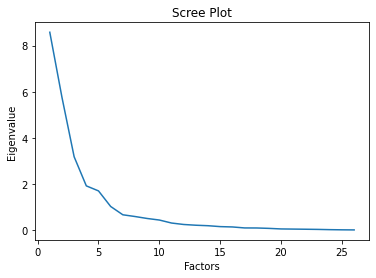

In [39]:
#Get Eigen values and plot them
ev, v = fa.get_eigenvalues()
ev
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.plot(range(1,x.shape[1]+1),ev)
plt.savefig('ev.png', dpi=200)

In [40]:
fa.get_factor_variance()

(array([6.72689407, 5.54667219, 4.12460871]),
 array([0.25872669, 0.21333355, 0.1586388 ]),
 array([0.25872669, 0.47206024, 0.63069904]))

In [41]:
fa = FactorAnalyzer(5, rotation='varimax')
fa.fit(x)
loads = fa.loadings_
print(loads)

[[ 0.81623007  0.1520743   0.31526692 -0.39825351 -0.00925943]
 [ 0.60005861 -0.13415285  0.37941848 -0.38402604  0.28027529]
 [-0.29510668 -0.11134758  0.10384572 -0.14553097  0.81670956]
 [ 0.06495204 -0.17781452 -0.00157213 -0.00977336  0.98287247]
 [-0.0338083   0.92204205  0.06214938 -0.16181035  0.04932986]
 [-0.58109755 -0.36414055  0.36341746 -0.31228342  0.45354652]
 [-0.25037453  0.75262034 -0.4069674   0.22437778 -0.07874691]
 [-0.58541172 -0.1793408  -0.56168298 -0.00528456 -0.01375899]
 [ 0.01159568  0.19975687  0.04072296  0.96606634 -0.16993466]
 [-0.22872999 -0.03393997  0.06424954  0.61841599 -0.06347516]
 [ 0.74510301 -0.25499475 -0.1897937   0.12800054  0.03303133]
 [ 0.78876529  0.18447307 -0.1547245   0.02266447 -0.15777036]
 [ 0.86884769  0.29452883  0.04097098 -0.18278538  0.12229411]
 [ 0.51299686  0.44606516 -0.34147798  0.1181313  -0.34515507]
 [ 0.45801756 -0.01098997 -0.6937055   0.23588049 -0.43585528]
 [-0.61922398 -0.20835543  0.41319585 -0.35658698  0.28

In [42]:
loads0 = pd.DataFrame(data=loads)
loads0

,0,1,2,3,4
0,0.816230,0.152074,0.315267,-0.398254,-0.009259
1,0.600059,-0.134153,0.379418,-0.384026,0.280275
2,-0.295107,-0.111348,0.103846,-0.145531,0.816710
3,0.064952,-0.177815,-0.001572,-0.009773,0.982872
4,-0.033808,0.922042,0.062149,-0.161810,0.049330
5,-0.581098,-0.364141,0.363417,-0.312283,0.453547
6,-0.250375,0.752620,-0.406967,0.224378,-0.078747
7,-0.585412,-0.179341,-0.561683,-0.005285,-0.013759
8,0.011596,0.199757,0.040723,0.966066,-0.169935
9,-0.228730,-0.033940,0.064250,0.618416,-0.063475


In [43]:
import pingouin as pg

C:\Users\18811\anaconda3\envs\sds2020\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning:

The package pingouin is out of date. Your version is 0.3.12, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.



In [44]:
for col in dfc.columns:
    print(col)

weight
volume
fat
saturate
salt
sugar
protein
fibre
alcohol
f_beer
f_dairy
f_eggs
f_fats_oils
f_fish
f_fruit_veg
f_grains
f_meat_red
f_poultry
f_readymade
f_sauces
f_soft_drinks
f_spirits
f_tea_coffee
f_water
f_wine
energy_density
h_nutrients_calories_norm


### '0weight','1volume','2fat','3saturate','4salt','5sugar','6protein','7fibre','8alcohol',
### '9f_beer','10f_dairy','11f_eggs','12f_fats_oils','13f_fish','14f_fruit_veg','15f_grains','16f_meat_red','17f_poultry',
### '18f_readymade','19f_sauces','20f_soft_drinks','21f_spirits','22f_tea_coffee','23f_water','24f_wine','25energy_density',
### '26h_nutrients_calories_norm'

In [45]:
#Create the factors
factor1 = dfc[['weight', 'volume', 'f_dairy', 'f_eggs','f_fats_oils','f_fish','f_fruit_veg']]
factor2 = dfc[['salt', 'protein', 'f_meat_red','f_poultry','f_sauces']]
factor3 = dfc[['f_soft_drinks', 'f_spirits', 'f_water']]
factor4 = dfc[['alcohol','f_beer','f_wine']]
factor5 = dfc[['fat','saturate']]
#Get cronbach alpha
factor1_alpha = pg.cronbach_alpha(factor1)
factor2_alpha = pg.cronbach_alpha(factor2)
factor3_alpha = pg.cronbach_alpha(factor3)
factor4_alpha = pg.cronbach_alpha(factor4)
factor5_alpha = pg.cronbach_alpha(factor5)
print(factor1_alpha, factor2_alpha, factor3_alpha, factor4_alpha, factor5_alpha)

(0.33951603668412267, array([0.257, 0.416])) (0.2697348370497957, array([0.175, 0.357])) (0.6257263048265091, array([0.572, 0.674])) (0.3656907188658633, array([0.274, 0.447])) (0.7944792338745443, array([0.76 , 0.824]))


In [46]:
scaled_df = pd.DataFrame(fa.fit_transform(dfc), index=dfc.index)
scaled_df

,0,1,2,3,4
GSS_CODE,,,,,
E05000026,0.850653,-0.283994,-0.876920,1.584463,0.561738
E05000027,-0.235723,-0.059447,-1.284498,0.744151,-1.116102
E05000028,0.183500,0.418676,1.268941,2.927408,0.423632
E05000029,0.153683,-0.790513,0.186942,2.660159,1.966219
E05000030,-0.834047,0.132444,-1.088705,0.532070,0.355662
...,...,...,...,...,...
E05000646,0.016905,1.532509,-0.629263,-0.150081,-0.842728
E05000647,0.316942,0.679470,1.953808,1.251152,-0.655985
E05000648,1.103403,-0.909402,-0.043773,-0.482615,-0.594549


## Kmeans

In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
import sklearn.cluster as sklc
import sklearn.metrics as sklm
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy import stats
from scipy.stats import bartlett
import plotly.graph_objs as go
import plotly.offline as py

In [48]:
#col = ['f_beer','f_dairy','f_eggs','f_fats_oils','f_fish','f_fruit_veg','f_grains','f_meat_red','f_poultry','f_readymade','f_sauces',
#       'f_soft_drinks','f_spirits','f_sweets','f_tea_coffee','f_water','f_wine']
#features = cat[col]
#remains = cat.drop(columns=col)
#scaler = StandardScaler()
#scaled_features = scaler.fit_transform(features)
#scaled_df = pd.DataFrame(scaled_features, index=cat.index, columns=col)

In [49]:
#data = pd.merge(remains, scaled_df, left_index=True, right_index=True, how='inner').set_index('area_id')
#data

In [50]:
data = scaled_df.rename(columns={0: 'Fundamental Nutrients',1: 'High Salt and Protein', 2: 'Soft Drinks and Spirits', 3: 'Other Alcohol', 4: 'Fat and Sugar'})
data.describe()

,Fundamental Nutrients,High Salt and Protein,Soft Drinks and Spirits,Other Alcohol,Fat and Sugar
count,6.250000e+02,6.250000e+02,6.250000e+02,6.250000e+02,6.250000e+02
mean,1.170974e-15,1.904255e-15,5.377387e-15,2.739853e-15,-1.291482e-14
std,1.002293e+00,9.869904e-01,1.154258e+00,1.151491e+00,1.059138e+00
min,-3.119290e+00,-3.357854e+00,-3.107843e+00,-4.567625e+00,-5.073649e+00
25%,-4.546412e-01,-6.731595e-01,-7.382504e-01,-7.216491e-01,-6.410794e-01
50%,2.093269e-01,3.107496e-02,-3.476483e-02,-4.019003e-02,-1.783392e-02
75%,6.549069e-01,6.800079e-01,6.736422e-01,7.561192e-01,5.627377e-01
max,3.174201e+00,2.553098e+00,4.892402e+00,3.567107e+00,4.550805e+00


In [51]:
x = data.iloc[:, [0,1,2,3,4]].values

# let's check the shape of x
print(x.shape)

(625, 5)


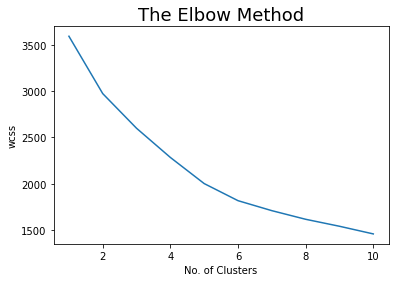

<Figure size 1008x720 with 0 Axes>

In [52]:
#sns.set_style("whitegrid")
wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(x)
    wcss.append(km.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 18)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.figure(figsize=(14,10))
plt.savefig('elbow.png', dpi=100)

In [53]:
k_cluster = 5
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(data)

KMeans(n_clusters=5, random_state=1)

In [54]:
data['Kmeans_Cluster'] = kmeans_method.labels_

In [55]:
to_plot = data.set_index('Kmeans_Cluster')

In [56]:
to_plot

,Fundamental Nutrients,High Salt and Protein,Soft Drinks and Spirits,Other Alcohol,Fat and Sugar
Kmeans_Cluster,,,,,
3,0.850653,-0.283994,-0.876920,1.584463,0.561738
4,-0.235723,-0.059447,-1.284498,0.744151,-1.116102
2,0.183500,0.418676,1.268941,2.927408,0.423632
2,0.153683,-0.790513,0.186942,2.660159,1.966219
0,-0.834047,0.132444,-1.088705,0.532070,0.355662
...,...,...,...,...,...
4,0.016905,1.532509,-0.629263,-0.150081,-0.842728
2,0.316942,0.679470,1.953808,1.251152,-0.655985
1,1.103403,-0.909402,-0.043773,-0.482615,-0.594549


In [57]:
to_plot2 = to_plot.groupby('Kmeans_Cluster').count()

In [58]:
to_plot2

,Fundamental Nutrients,High Salt and Protein,Soft Drinks and Spirits,Other Alcohol,Fat and Sugar
Kmeans_Cluster,,,,,
0,109,109,109,109,109
1,171,171,171,171,171
2,89,89,89,89,89
3,75,75,75,75,75
4,181,181,181,181,181


In [59]:
to_plot = to_plot.stack()
to_plot = to_plot.reset_index()
to_plot = to_plot.rename(columns={'level_1': 'type', 0: 'Values'})

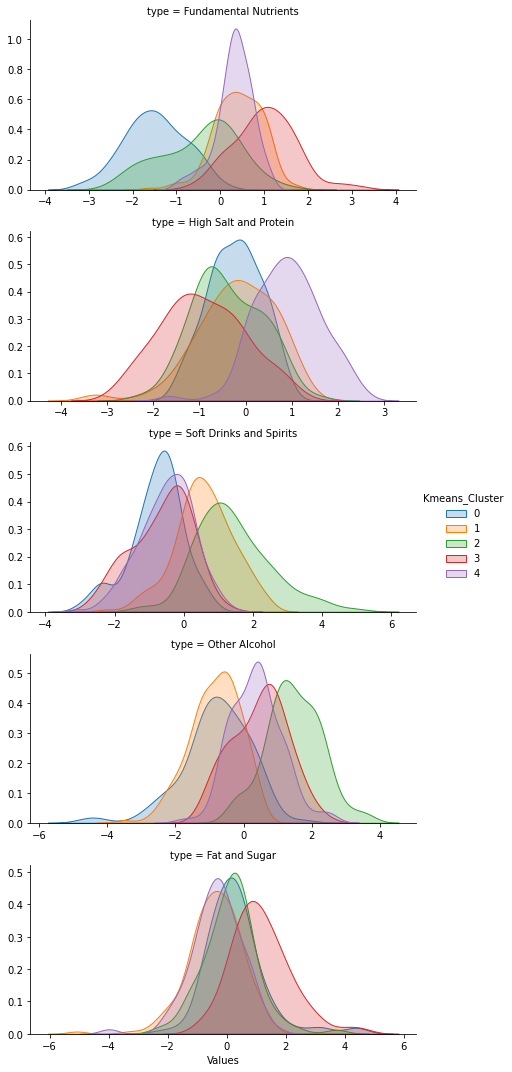

In [60]:
facets = sns.FacetGrid(data=to_plot, row='type', hue='Kmeans_Cluster',
                  sharey=False, sharex=False, aspect=2)
kpt = facets.map(sns.kdeplot, 'Values', shade=True).add_legend()

In [61]:
from sklearn.metrics import silhouette_score

In [62]:
silhouette_avg0 = silhouette_score(data, kmeans_method.labels_)

In [63]:
silhouette_avg0

0.3137582462310734

In [64]:
agglom_means = data.groupby("Kmeans_Cluster").mean()
agglom_means

,Fundamental Nutrients,High Salt and Protein,Soft Drinks and Spirits,Other Alcohol,Fat and Sugar
Kmeans_Cluster,,,,,
0,-1.489457,-0.233432,-0.792502,-0.797082,0.296081
1,0.409595,-0.207200,0.580822,-0.840177,-0.406561
2,-0.465535,-0.390943,1.419348,1.461615,0.129106
3,1.015582,-0.930495,-0.650084,0.461631,1.159742
4,0.318088,0.914123,-0.500019,0.363791,-0.338243


In [65]:
cout = data.groupby("Kmeans_Cluster").count()
cout

,Fundamental Nutrients,High Salt and Protein,Soft Drinks and Spirits,Other Alcohol,Fat and Sugar
Kmeans_Cluster,,,,,
0,109,109,109,109,109
1,171,171,171,171,171
2,89,89,89,89,89
3,75,75,75,75,75
4,181,181,181,181,181


In [66]:
#Transpose index and columns.
agglom_means_T = agglom_means.T.round(3)
agglom_means_T

Kmeans_Cluster,0,1,2,3,4
Fundamental Nutrients,-1.489,0.410,-0.466,1.016,0.318
High Salt and Protein,-0.233,-0.207,-0.391,-0.930,0.914
Soft Drinks and Spirits,-0.793,0.581,1.419,-0.650,-0.500
Other Alcohol,-0.797,-0.840,1.462,0.462,0.364
Fat and Sugar,0.296,-0.407,0.129,1.160,-0.338


In [67]:
#agglom_means_T.reset_index(inplace=True)
agglom_means_T = pd.DataFrame(agglom_means_T)

agglom_means_T

Kmeans_Cluster,0,1,2,3,4
Fundamental Nutrients,-1.489,0.410,-0.466,1.016,0.318
High Salt and Protein,-0.233,-0.207,-0.391,-0.930,0.914
Soft Drinks and Spirits,-0.793,0.581,1.419,-0.650,-0.500
Other Alcohol,-0.797,-0.840,1.462,0.462,0.364
Fat and Sugar,0.296,-0.407,0.129,1.160,-0.338


C:\Users\18811\AppData\Local\Temp/ipykernel_15192/2449544760.py:19: UserWarning:

FixedFormatter should only be used together with FixedLocator



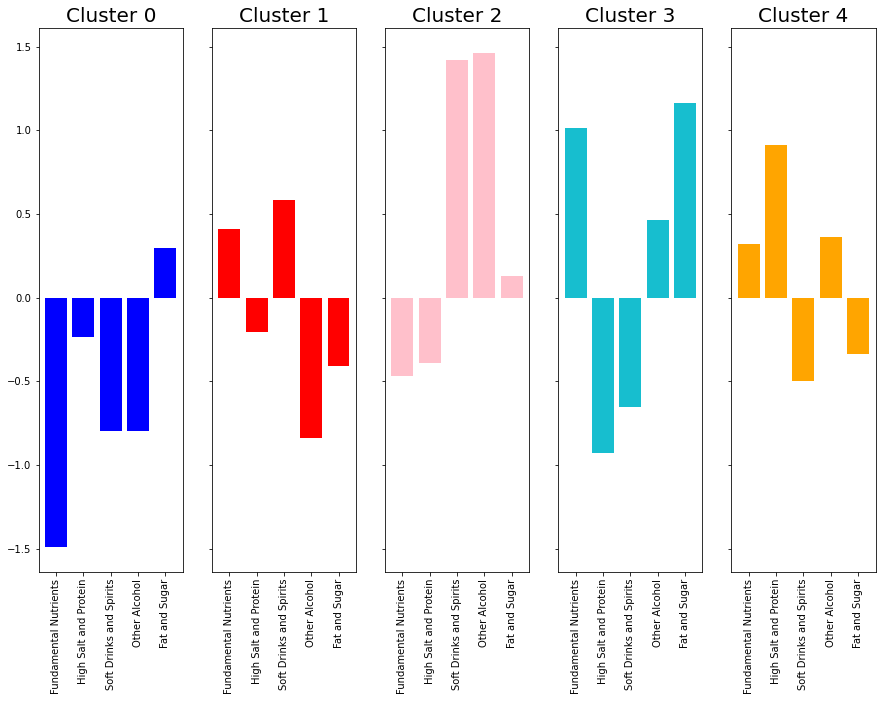

In [68]:
agglom_means_T.reset_index(inplace=True)

#get the colour
colors = ["blue", "red", "pink", "tab:cyan", "orange"]

#create subplots for each cluster
fig, ax = plt.subplots(1,5, figsize = (15,10), sharey = True, sharex = True)
#flatten the axis
axis = ax.flatten()

#going over each column
for i, col  in enumerate(agglom_means_T.columns):
    #ignore the index column
    if col != "index":
        ax = axis[i-1]
        #plot the bar chart
        ax.bar(height = agglom_means_T[col], x=agglom_means_T["index"], color = colors[i-1] )
        #rotate the x-ticks
        ax.set_xticklabels(labels =agglom_means_T["index"], rotation = 90)
        #set the title
        ax.set_title(f"Cluster {col}", fontsize = 20)

plt.savefig('result_k.png', dpi=400)

In [69]:
wardmap = pd.merge(data, ward, how='left', left_on='GSS_CODE', right_on='GSS_CODE')

In [70]:
wardmaps = gpd.GeoDataFrame(wardmap, geometry='geometry')

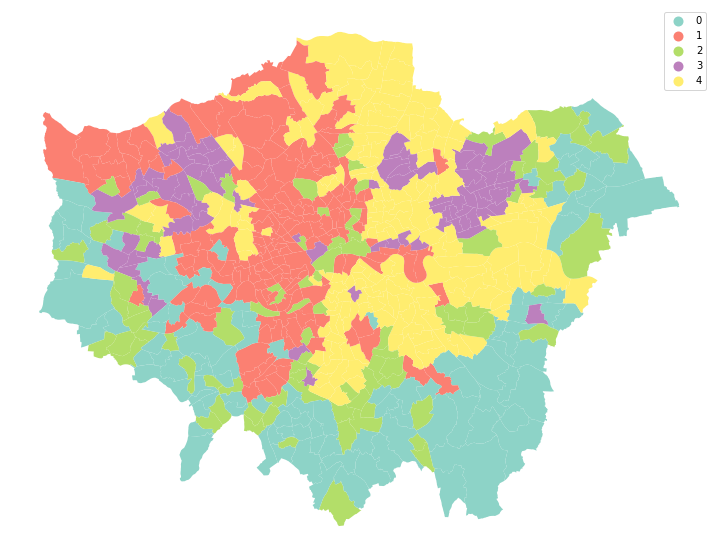

In [71]:
wardmaps.plot(column='Kmeans_Cluster', categorical=True, cmap='Set3', legend=True, figsize=(14,10))
plt.axis('off')
#plt.legend(title='Clusters')
plt.savefig('kclustering.png', dpi=400)

In [72]:
atlas = pd.read_csv('ward-profiles-excel-version.csv')

In [73]:
for col in atlas.columns:
    print(col)

Ward name
Old code
New code
Population - 2015
Children aged 0-15 - 2015
Working-age (16-64) - 2015
Older people aged 65+ - 2015
% All Children aged 0-15 - 2015
% All Working-age (16-64) - 2015
% All Older people aged 65+ - 2015
Mean Age - 2013
Median Age - 2013
Area - Square Kilometres
Population density (persons per sq km) - 2013
% BAME - 2011
% Not Born in UK - 2011
% English is First Language of no one in household - 2011
General Fertility Rate - 2013
Male life expectancy -2009-13
Female life expectancy -2009-13 
% children in reception year who are obese - 2011/12 to 2013/14
% children in year 6 who are obese- 2011/12 to 2013/14
Rate of All Ambulance Incidents per 1,000 population - 2014
Rates of ambulance call outs for alcohol related illness - 2014
Number Killed or Seriously Injured on the roads - 2014
In employment (16-64) - 2011
Employment rate (16-64) - 2011
Number of jobs in area - 2013
Employment per head of resident WA population - 2013
Rate of new registrations of migrant 

In [74]:
atlas0 = atlas[['New code','% All Working-age (16-64) - 2015', '% children in reception year who are obese - 2011/12 to 2013/14',
                '% English is First Language of no one in household - 2011',
                'Median Household income estimate (2012/13)',
                '(ID2010) % of LSOAs in worst 50% nationally - 2010']].copy()

In [75]:
wardmap2 = pd.merge(wardmap, atlas0, how='left', left_on='GSS_CODE', right_on='New code')

In [76]:
wardmap2.drop_duplicates(subset=None, keep='first', inplace=True)

In [77]:
wardmap2

,GSS_CODE,Fundamental Nutrients,High Salt and Protein,Soft Drinks and Spirits,Other Alcohol,Fat and Sugar,Kmeans_Cluster,NAME,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry,New code,% All Working-age (16-64) - 2015,% children in reception year who are obese - 2011/12 to 2013/14,% English is First Language of no one in household - 2011,Median Household income estimate (2012/13),(ID2010) % of LSOAs in worst 50% nationally - 2010
0,E05000026,0.850653,-0.283994,-0.876920,1.584463,0.561738,3,Abbey,128.292,2.655,E09000002,Barking and Dagenham,51353,"POLYGON ((543595.500 184832.800, 543601.700 18...",E05000026,69.0,13.3,25.7,33920.0,85.7
1,E05000027,-0.235723,-0.059447,-1.284498,0.744151,-1.116102,4,Alibon,136.442,0.000,E09000002,Barking and Dagenham,117020,"POLYGON ((547932.400 184916.600, 547944.800 18...",E05000027,64.3,10.0,7.9,32470.0,100.0
2,E05000028,0.183500,0.418676,1.268941,2.927408,0.423632,2,Becontree,128.809,0.000,E09000002,Barking and Dagenham,117018,"POLYGON ((546209.400 185783.600, 546219.300 18...",E05000028,65.9,12.3,10.5,33000.0,100.0
3,E05000029,0.153683,-0.790513,0.186942,2.660159,1.966219,2,Chadwell Heath,338.422,0.000,E09000002,Barking and Dagenham,117014,"POLYGON ((547715.200 187914.200, 547712.500 18...",E05000029,61.5,12.8,6.5,33920.0,100.0
4,E05000030,-0.834047,0.132444,-1.088705,0.532070,0.355662,0,Eastbrook,345.060,0.000,E09000002,Barking and Dagenham,50856,"POLYGON ((549991.500 184928.500, 549988.900 18...",E05000030,65.7,12.6,4.5,37400.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,E05000646,0.016905,1.532509,-0.629263,-0.150081,-0.842728,4,Vincent Square,68.355,8.890,E09000033,Westminster,117485,"POLYGON ((529351.000 178739.600, 529265.800 17...",E05000646,73.1,10.0,17.0,46550.0,100.0
621,E05000647,0.316942,0.679470,1.953808,1.251152,-0.655985,2,Warwick,57.354,0.000,E09000033,Westminster,50794,"POLYGON ((529030.000 179150.400, 529063.700 17...",E05000647,77.0,13.5,15.9,50250.0,60.0
622,E05000648,1.103403,-0.909402,-0.043773,-0.482615,-0.594549,1,Westbourne,67.646,0.000,E09000033,Westminster,50566,"POLYGON ((526032.200 181629.400, 526022.700 18...",E05000648,70.2,11.7,24.1,32390.0,100.0
623,E05000649,0.674652,-0.042394,0.572209,-0.183331,1.130184,3,West End,199.973,0.000,E09000033,Westminster,50723,"POLYGON ((529928.500 181049.000, 529921.300 18...",E05000649,79.8,NaN,24.2,54970.0,60.0


In [78]:
#wardmaps2 = gpd.GeoDataFrame(wardmap2, geometry='geometry')

In [79]:
pro0 = wardmap2[['New code','% All Working-age (16-64) - 2015', '% children in reception year who are obese - 2011/12 to 2013/14',
                '% English is First Language of no one in household - 2011',
                'Median Household income estimate (2012/13)',
                '(ID2010) % of LSOAs in worst 50% nationally - 2010', 'Kmeans_Cluster']].copy()

In [80]:
pro = pro0.groupby("Kmeans_Cluster").mean()

In [81]:
pro

,% All Working-age (16-64) - 2015,% children in reception year who are obese - 2011/12 to 2013/14,% English is First Language of no one in household - 2011,Median Household income estimate (2012/13),(ID2010) % of LSOAs in worst 50% nationally - 2010
Kmeans_Cluster,,,,,
0,64.618349,8.612844,6.075229,40381.651376,34.515596
1,70.966667,9.029487,14.153216,45194.912281,55.794152
2,67.688764,10.436364,11.558427,38406.853933,64.656180
3,67.481333,11.198649,20.966667,34632.266667,78.636000
4,68.974033,12.246961,12.986740,35327.348066,88.456354
